# softmax回归的从零开始实现

这一节我们来动手实现softmax回归。首先导入本节实现所需的包或模块。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

## 获取和读取数据

我们将使用Fashion-MNIST数据集，并设置批量大小为256。

In [2]:
batch_size = 5
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

跟线性回归中的例子一样，我们将使用向量表示每个样本。已知每个样本输入是高和宽均为28像素的图像。模型的输入向量的长度是$28 \times 28 = 784$：该向量的每个元素对应图像中每个像素。由于图像有10个类别，单层神经网络输出层的输出个数为10，因此softmax回归的权重和偏差参数分别为$784 \times 10$和$1 \times 10$的矩阵。

In [3]:
num_inputs = 784
num_outputs = 10

W = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
b = nd.zeros(num_outputs)

同之前一样，我们要为模型参数附上梯度。

In [4]:
W.attach_grad()
b.attach_grad()

## 实现softmax运算

在介绍如何定义softmax回归之前，我们先描述一下对如何对多维`NDArray`按维度操作。在下面的例子中，给定一个`NDArray`矩阵`X`。我们可以只对其中同一列（`axis=0`）或同一行（`axis=1`）的元素求和，并在结果中保留行和列这两个维度（`keepdims=True`）。

In [5]:
X = nd.array([[1, 2, 3], [4, 5, 6]])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>, 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

下面我们就可以定义前面小节里介绍的softmax运算了。在下面的函数中，矩阵`X`的行数是样本数，列数是输出个数。为了表达样本预测各个输出的概率，softmax运算会先通过`exp`函数对每个元素做指数运算，再对`exp`矩阵同行元素求和，最后令矩阵每行各元素与该行元素之和相除。这样一来，最终得到的矩阵每行元素和为1且非负。因此，该矩阵每行都是合法的概率分布。softmax运算的输出矩阵中的任意一行元素代表了一个样本在各个输出类别上的预测概率。

In [6]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

可以看到，对于随机输入，我们将每个元素变成了非负数，且每一行和为1。

In [7]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.6264712  0.126293   0.01826552 0.10885343 0.12011679]
  [0.25569436 0.2917251  0.07546549 0.3024068  0.07470828]]
 <NDArray 2x5 @cpu(0)>, 
 [0.99999994 1.        ]
 <NDArray 2 @cpu(0)>)

## 定义模型

有了softmax运算，我们可以定义上节描述的softmax回归模型了。这里通过`reshape`函数将每张原始图像改成长度为`num_inputs`的向量。

In [8]:
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 定义损失函数

上一节中，我们介绍了softmax回归使用的交叉熵损失函数。为了得到标签的预测概率，我们可以使用`pick`函数。在下面的例子中，变量`y_hat`是2个样本在3个类别的预测概率，变量`y`是这2个样本的标签类别。通过使用`pick`函数，我们得到了2个样本的标签的预测概率。与[“softmax回归”](softmax-regression.ipynb)一节数学表述中标签类别离散值从1开始逐一递增不同，在代码中，标签类别的离散值是从0开始逐一递增的。

In [42]:
y_hat = nd.array([[0.14341575, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = nd.array([0, 1], dtype='int32')
nd.pick(y_hat, y)


[0.14341575 0.2       ]
<NDArray 2 @cpu(0)>

下面实现了[“softmax回归”](softmax-regression.ipynb)一节中介绍的交叉熵损失函数。

In [32]:
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

In [43]:
cross_entropy(y_hat, y)


[1.9420075 1.609438 ]
<NDArray 2 @cpu(0)>

In [18]:
from mxnet import gluon

In [19]:
los = gluon.loss.SoftmaxCrossEntropyLoss()

In [37]:
los(y_hat, y)


[1.4283894 1.239831 ]
<NDArray 2 @cpu(0)>

## 计算分类准确率

给定一个类别的预测概率分布`y_hat`，我们把预测概率最大的类别作为输出类别。如果它与真实类别`y`一致，说明这次预测是正确的。分类准确率即正确预测数量与总预测数量之比。

为了演示准确率的计算，下面定义准确率`accuracy`函数。其中`y_hat.argmax(axis=1)`返回矩阵`y_hat`每行中最大元素的索引，且返回结果与变量`y`形状相同。我们在[“数据操作”](../chapter_prerequisite/ndarray.ipynb)一节介绍过，相等条件判断式`(y_hat.argmax(axis=1) == y)`是一个值为0（相等为假）或1（相等为真）的`NDArray`。由于标签类型为整数，我们先将变量`y`变换为浮点数再进行相等条件判断。

In [12]:
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

让我们继续使用在演示`pick`函数时定义的变量`y_hat`和`y`，并将它们分别作为预测概率分布和标签。可以看到，第一个样本预测类别为2（该行最大元素0.6在本行的索引为2），与真实标签0不一致；第二个样本预测类别为2（该行最大元素0.5在本行的索引为2），与真实标签2一致。因此，这两个样本上的分类准确率为0.5。

In [13]:
accuracy(y_hat, y)

0.5

类似地，我们可以评价模型`net`在数据集`data_iter`上的准确率。

In [14]:
# 本函数已保存在d2lzh包中方便以后使用。该函数将被逐步改进：它的完整实现将在“图像增广”一节中
# 描述
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

因为我们随机初始化了模型`net`，所以这个随机模型的准确率应该接近于类别个数10的倒数0.1。

In [15]:
evaluate_accuracy(test_iter, net)

0.0856

## 训练模型

训练softmax回归的实现跟[“线性回归的从零开始实现”](linear-regression-scratch.ipynb)一节介绍的线性回归中的实现非常相似。我们同样使用小批量随机梯度下降来优化模型的损失函数。在训练模型时，迭代周期数`num_epochs`和学习率`lr`都是可以调的超参数。改变它们的值可能会得到分类更准确的模型。

In [28]:

num_epochs, lr = 5, 0.1

# 本函数已保存在d2lzh包中方便以后使用
def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                print(y_hat, y[0])
                print(type(y_hat), type(y[0]))
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)  # “softmax回归的简洁实现”一节将用到
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size,
          [W, b], lr)


[[5.2216698e-09 2.0827137e-07 2.7524166e-07 1.1556115e-04 2.0391450e-08
  2.0746319e-03 4.0318114e-06 9.9732882e-01 1.5708973e-05 4.6074719e-04]
 [1.5387061e-12 2.6164775e-11 7.8711498e-10 3.0951023e-07 8.2044647e-09
  3.2814000e-02 5.9669148e-08 8.4667176e-01 1.3276330e-03 1.1918625e-01]
 [3.1214853e-08 2.0220146e-05 9.9746656e-01 4.3779237e-06 2.3821455e-03
  2.2340735e-11 1.2588984e-04 3.6724820e-12 8.0495755e-07 5.7141027e-13]
 [1.8338023e-10 4.5094502e-08 4.0663450e-05 1.3507267e-07 1.2533871e-03
  7.6911486e-14 9.9870569e-01 7.4557630e-19 4.3006843e-08 6.1848010e-17]
 [2.5893911e-05 1.7207167e-04 3.5263458e-03 9.9332118e-01 3.2989076e-06
  1.0448070e-11 2.9511601e-03 2.0100193e-09 1.9190260e-08 7.9982487e-10]]
<NDArray 5x10 @cpu(0)> 
[7]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[7.14253261e-08 2.62160779e-06 3.37727179e-05 1.53165089e-03
  1.03271132e-05 8.97584975e-01 5.82243456e-06 9.79778096e-02
  2.40853615e-03 4.4

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.4118147e-10 1.5175586e-11 3.8742957e-08 1.6676573e-11 1.7503332e-04
  2.3026865e-10 4.6769801e-09 1.6076324e-10 9.9982494e-01 6.6533418e-10]
 [4.5454562e-06 4.7646833e-04 9.5913565e-01 1.0404504e-05 4.0372491e-02
  2.4484307e-15 3.7366416e-07 2.1328808e-15 6.2198731e-09 1.3463795e-15]
 [1.8728375e-02 1.1591020e-03 1.5869643e-01 7.5381282e-03 1.3228701e-01
  1.1854169e-03 6.7525935e-01 2.4275971e-06 5.1424871e-03 1.3441773e-06]
 [8.2620094e-03 2.1367754e-05 2.9166264e-04 5.2614260e-04 4.5124598e-02
  2.2306601e-11 9.4559872e-01 3.7937061e-13 1.7543472e-04 5.8341773e-14]
 [1.4687531e-11 5.9695963e-11 2.2802250e-11 1.1549778e-07 2.3635216e-10
  1.7827816e-04 1.3978799e-09 9.7899765e-01 3.7938957e-05 2.0786090e-02]]
<NDArray 5x10 @cpu(0)> 
[8]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.9070910e-10 1.1303962e-15 5.6955334e-15 5.1576132e-13 8.2614

<NDArray 5x10 @cpu(0)> 
[5]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.33193441e-06 1.06207301e-08 3.59147475e-06 3.10033738e-06
  4.11402794e-07 9.50311065e-01 1.52309203e-05 2.25984659e-02
  2.08457205e-02 6.22004829e-03]
 [2.11133860e-10 1.09865678e-05 1.18647858e-05 8.20939849e-09
  9.97455418e-01 1.08973095e-12 2.52173375e-03 2.29937681e-15
  9.06481112e-09 6.91252365e-15]
 [7.07192570e-02 6.13108158e-01 1.72422515e-04 3.00773621e-01
  3.32832150e-03 2.50806398e-09 4.72032977e-03 1.20555625e-04
  7.05346232e-03 3.88897115e-06]
 [9.65731382e-01 5.44140465e-04 7.66179219e-05 3.74414329e-03
  9.23406773e-09 1.20553949e-08 2.99030971e-02 1.13785674e-07
  3.61253740e-07 1.31073847e-07]
 [1.16109019e-04 1.01749238e-03 6.80443350e-07 7.05514103e-02
  9.24705803e-01 5.35097617e-12 1.00138551e-03 7.56419695e-07
  2.60628457e-03 2.79797097e-09]]
<NDArray 5x10 @cpu(0)> 
[5]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray

<NDArray 5x10 @cpu(0)> 
[7]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.1579366e-03 2.9507108e-04 8.9198196e-01 1.0218022e-03 1.2903107e-05
  1.8709610e-05 1.0446133e-01 3.8411764e-07 4.9751863e-05 1.1085399e-07]
 [5.3026326e-07 9.9999744e-01 8.9924960e-08 1.1127262e-06 7.6778622e-07
  3.3496214e-15 6.0586579e-12 5.3189408e-10 1.7361100e-09 3.4679283e-13]
 [8.8623565e-06 3.5806315e-06 1.4765575e-08 9.9997604e-01 1.8254365e-08
  4.2333036e-11 5.3166013e-06 2.3108096e-10 6.1564401e-06 1.0069383e-08]
 [1.6455375e-10 5.1251003e-11 6.3893012e-08 1.3528941e-08 8.5601141e-07
  1.0441728e-07 3.3406635e-05 1.1722474e-10 9.9996561e-01 9.9042261e-14]
 [1.1201231e-01 2.3983822e-03 1.5806371e-01 8.0165348e-04 6.0304126e-05
  6.3495459e-06 7.0478600e-01 1.2487814e-09 2.1871293e-02 1.5385755e-09]]
<NDArray 5x10 @cpu(0)> 
[2]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[7.1350291e-07 

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[8.0790305e-06 2.9433354e-06 2.4309955e-07 9.9995095e-01 3.7727888e-05
  4.7899130e-14 7.9959271e-08 9.1691078e-11 1.0550349e-09 1.4844524e-10]
 [4.4544404e-03 5.0338362e-03 5.0738892e-03 2.5683412e-02 2.8550500e-04
  9.3064523e-01 3.5438491e-03 1.7773548e-02 7.2635380e-03 2.4270217e-04]
 [5.1932549e-03 5.0296099e-03 5.8189835e-06 9.8945445e-01 1.1341870e-06
  1.9529645e-09 4.2158204e-06 4.3070257e-05 2.6822355e-04 1.7748279e-07]
 [3.3052932e-04 8.3582017e-06 9.9893260e-01 9.4046045e-05 1.6474097e-04
  1.7757669e-11 4.6914379e-04 1.6773409e-12 5.5071592e-07 4.7896707e-13]
 [5.1504878e-07 9.9998105e-01 2.7047897e-09 2.6907472e-08 1.8443498e-05
  4.9329340e-19 1.0134088e-14 1.8543274e-10 2.3772825e-10 1.1532511e-13]]
<NDArray 5x10 @cpu(0)> 
[3]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.2307438e-05 9.9986356e-01 4.5480541e-05 5.6647394e-05 1.1659


[[4.9580027e-08 1.8417030e-06 9.9970752e-01 1.2859145e-06 2.8662168e-04
  6.7237441e-14 7.9709366e-08 2.2218096e-15 2.6379089e-06 4.4979186e-15]
 [7.8204387e-01 2.6587573e-05 4.0642012e-04 6.9907249e-04 1.2190800e-06
  2.8001156e-15 2.1682224e-01 1.2884536e-14 5.5623934e-07 1.7551543e-13]
 [3.5899740e-07 9.9972087e-01 6.8344007e-06 2.2554079e-04 4.5974590e-05
  8.5100769e-13 3.9172390e-09 1.3136775e-09 2.2306306e-09 3.7452898e-07]
 [4.4865083e-06 8.6941839e-08 3.3759054e-06 1.1561121e-04 7.2007850e-08
  2.1635327e-01 1.1221700e-05 7.3693556e-01 2.5588875e-03 4.4017464e-02]
 [8.0058919e-07 4.3113469e-06 5.2765617e-03 1.0224622e-02 7.4693024e-05
  2.7900637e-06 2.5430732e-04 1.0601737e-05 9.8412687e-01 2.4514378e-05]]
<NDArray 5x10 @cpu(0)> 
[2]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.13202264e-04 9.18718615e-06 3.31564638e-06 9.99773800e-01
  1.57701630e-09 2.33333458e-15 4.81747122e-07 5.85308824e-09
  5.11656106e-10 4.4

<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.3778990e-09 6.1559192e-08 4.7304337e-07 2.5675368e-05 1.5461492e-07
  7.2864592e-02 1.1463997e-06 9.2350167e-01 2.7589116e-03 8.4734580e-04]
 [1.4234591e-07 9.9998170e-01 4.0536733e-08 3.0588183e-07 1.7801107e-05
  4.6999391e-16 8.0069831e-12 4.8309915e-11 1.3335079e-10 1.6369512e-12]
 [7.1094328e-14 2.0662669e-10 8.8536552e-07 2.0803012e-12 9.9999911e-01
  3.2387163e-18 1.9780011e-08 4.7327987e-19 2.8234630e-09 5.5679383e-19]
 [8.5697829e-05 1.4648307e-05 2.5566723e-02 9.9912404e-06 5.7174494e-03
  6.7215689e-05 7.7811241e-01 4.7760935e-08 1.9032764e-01 9.8150864e-05]
 [2.8523209e-05 9.4979638e-03 9.3016320e-07 1.9667852e-03 9.8621780e-01
  2.9269645e-15 1.9624236e-03 1.0000673e-07 3.2550484e-04 8.6359639e-09]]
<NDArray 5x10 @cpu(0)> 
[7]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.3208349e-08 

<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[6.90016866e-01 4.43678611e-04 3.90257197e-03 1.60370544e-02
  2.67451338e-04 3.37814618e-06 2.88567185e-01 9.42999395e-06
  7.50213163e-04 2.18273590e-06]
 [6.54147070e-10 2.00588524e-09 3.81908087e-08 4.08087146e-07
  6.67365746e-11 1.16771751e-03 1.16160706e-07 9.98029113e-01
  5.37636515e-05 7.48772407e-04]
 [3.18031084e-07 1.41842675e-05 5.19554257e-01 2.81733634e-07
  4.80172902e-01 4.30612678e-14 2.09390520e-04 8.93580266e-16
  4.86408753e-05 3.77399699e-17]
 [1.19193089e-09 9.49562998e-12 1.11223153e-05 8.36874303e-09
  3.33771304e-08 3.20808823e-07 4.05205071e-07 3.31343602e-14
  9.99988079e-01 7.65982217e-16]
 [5.96710095e-08 3.37791647e-07 9.98717070e-01 1.35375435e-08
  1.21955574e-03 1.06516772e-13 8.05068339e-06 2.33837048e-14
  5.48787248e-05 2.42785604e-15]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray


[[7.4204922e-02 3.2844334e-03 1.3057099e-01 7.5733763e-01 2.6946407e-02
  1.6058430e-03 2.2006575e-04 1.6921596e-04 5.6506591e-03 9.8135552e-06]
 [1.5539369e-09 1.9316737e-07 8.4584926e-08 2.2842426e-06 2.6374547e-08
  9.8598129e-01 2.5586429e-08 1.3771178e-02 1.3761167e-04 1.0731920e-04]
 [2.0279181e-07 9.9999869e-01 3.6345426e-08 3.9168478e-07 7.0392844e-07
  2.7064752e-13 9.6213575e-13 1.2686198e-10 6.6222583e-10 1.0826928e-11]
 [9.1653398e-08 8.6649365e-05 9.9623030e-01 1.1659840e-07 3.6302065e-03
  1.9739164e-14 5.2595711e-05 7.3603966e-20 2.6890309e-08 1.1721251e-16]
 [9.4132820e-06 1.1840172e-03 9.9637089e-03 2.2530064e-04 6.4255702e-03
  1.6618894e-06 9.8218876e-01 3.3275713e-14 1.6634303e-06 2.8696540e-12]]
<NDArray 5x10 @cpu(0)> 
[3]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.0896922e-11 1.0000000e+00 1.6911930e-10 1.5084993e-09 7.6845436e-10
  4.9110586e-23 1.8519858e-19 1.9553976e-14 1.5329240e-14 1.3692640e-16]

<NDArray 5x10 @cpu(0)> 
[1]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.92789447e-01 7.11547793e-04 5.47871878e-03 6.61184546e-04
  1.38910821e-07 3.95214889e-10 3.57233104e-04 6.87143842e-10
  1.69470320e-06 4.38943659e-10]
 [5.56148356e-04 1.86189027e-05 3.80191021e-04 1.32280125e-04
  1.39888625e-05 9.94277298e-01 1.80219847e-03 1.30945933e-03
  7.29340944e-04 7.80511124e-04]
 [3.22456262e-09 1.81535682e-07 1.95165853e-06 8.23928785e-05
  1.38675148e-07 8.18732604e-02 9.03484221e-08 9.17611122e-01
  1.94895110e-04 2.36015170e-04]
 [5.29741010e-06 5.28561077e-06 5.43514652e-05 3.50428373e-03
  1.25723557e-06 9.93771255e-01 9.45035717e-05 2.14394167e-04
  9.14740594e-05 2.25793384e-03]
 [6.41815066e-01 3.07102862e-04 2.84015477e-01 6.82908520e-02
  9.94540387e-05 4.14656373e-13 5.46054123e-03 8.67976102e-17
  1.15366329e-05 2.42460661e-15]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray

<NDArray 5x10 @cpu(0)> 
[2]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.97621000e-01 1.66470908e-08 1.96888484e-03 4.09701490e-04
  8.45544260e-11 1.01305730e-18 4.08507020e-07 1.43782083e-16
  1.44120882e-10 2.06873779e-15]
 [1.51136983e-13 3.10492562e-18 1.01476119e-12 6.76883298e-16
  1.09911223e-19 5.89350429e-06 8.41911108e-15 1.97354007e-06
  1.76119443e-07 9.99991953e-01]
 [8.85776899e-05 1.41157685e-07 9.10490708e-05 2.92139089e-06
  9.53698600e-06 5.96368045e-06 1.83178327e-05 3.09229426e-06
  9.99780297e-01 5.20982866e-08]
 [4.40351968e-08 6.39640518e-09 8.32731075e-06 6.25795167e-08
  4.40391404e-11 8.84831429e-01 3.14522297e-11 9.71835543e-05
  2.39713768e-06 1.15060516e-01]
 [5.58444517e-05 5.16296277e-05 8.07462811e-07 9.99891520e-01
  1.52448179e-10 7.98540514e-14 3.21855867e-12 6.80097437e-11
  2.01728753e-07 6.86140519e-11]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[4.1578677e-08 1.0679877e-07 9.9999195e-01 1.2984769e-09 6.0295320e-06
  5.2821633e-17 1.8231232e-06 9.8168751e-19 5.5228100e-10 4.0059919e-15]
 [8.9786863e-03 9.5986664e-01 2.8519815e-02 1.0049789e-03 1.6284036e-03
  4.8280948e-09 1.2076353e-06 1.0683013e-08 2.3127984e-07 4.6091647e-10]
 [2.6643250e-09 4.8096149e-10 1.5603115e-05 3.1116683e-04 3.3728402e-06
  1.7772276e-05 4.0091967e-05 2.1187327e-08 9.9907035e-01 5.4171146e-04]
 [4.7913447e-04 8.6741423e-04 4.8602975e-05 9.9858826e-01 9.8923529e-06
  6.3755702e-12 1.0412678e-06 5.0773021e-08 5.5471596e-06 1.3964419e-08]
 [1.4203764e-03 3.6556605e-04 4.0949848e-03 2.6615248e-03 2.3513705e-04
  9.2337036e-01 9.0208370e-04 6.4638712e-02 1.9792013e-03 3.3213521e-04]]
<NDArray 5x10 @cpu(0)> 
[2]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.4909362e-09 9.1221621e-11 1.7923738e-07 1.1363462e-07 3.8979

<NDArray 5x10 @cpu(0)> 
[5]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[7.7656729e-08 2.5744583e-07 8.9275151e-01 7.7709188e-08 1.0659539e-01
  1.1358812e-12 6.1761489e-04 5.0936648e-15 3.5107587e-05 5.5645335e-14]
 [1.9362515e-06 9.6413777e-10 1.3531108e-07 8.2642416e-08 2.9867095e-11
  4.4070976e-03 1.1772967e-06 9.8624682e-01 3.1902967e-04 9.0237437e-03]
 [6.4048870e-04 7.0291171e-05 5.1009476e-01 4.8914304e-01 4.6331934e-05
  2.6628605e-20 4.9282162e-06 7.1708942e-14 1.8432667e-07 5.0852957e-15]
 [4.8891524e-10 1.0532962e-14 5.8498102e-07 3.5868760e-12 1.1623056e-14
  5.8108959e-05 1.5579822e-08 5.7525293e-04 1.7416760e-04 9.9919182e-01]
 [3.4778089e-09 3.1062770e-12 1.3498169e-08 9.0348520e-09 6.8194053e-12
  6.2645008e-03 3.2413058e-07 2.3580652e-01 3.2071836e-04 7.5760794e-01]]
<NDArray 5x10 @cpu(0)> 
[4]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[5.1858312e-01 

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.6680236e-01 3.7056368e-04 1.5449102e-02 6.7673950e-03 5.0798400e-05
  4.2724931e-08 1.0534042e-02 2.9544571e-08 2.5668045e-05 2.1739565e-08]
 [5.4722384e-04 9.3265206e-01 5.6188954e-03 5.6983963e-02 3.7659311e-03
  2.7451640e-06 1.5302346e-04 3.8707683e-05 7.9708923e-05 1.5770689e-04]
 [2.4992770e-02 7.4518020e-03 7.8476798e-05 9.6721035e-01 4.1588748e-07
  2.4934418e-15 4.1850937e-05 1.2015475e-11 2.2437540e-04 1.4930131e-13]
 [9.9884808e-01 3.0495170e-07 1.1811785e-04 5.8574606e-05 1.4106155e-13
  1.3939388e-23 9.7493816e-04 8.8964946e-18 1.1343266e-10 4.9155106e-16]
 [4.6204207e-07 7.2837222e-11 5.1866268e-06 2.6299586e-11 1.4866921e-09
  5.1114717e-13 2.0654472e-06 3.4515832e-10 9.9999183e-01 4.9194432e-07]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[5.6822544e-05 1.5602345e-03 1.4321938e-05 9.9821973e-01 5.3530

<NDArray 5x10 @cpu(0)> 
[4]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[7.8718445e-14 2.5648647e-17 3.8317496e-12 8.1054700e-16 4.5478209e-19
  8.0563275e-08 5.2463671e-12 5.6438616e-08 4.3154271e-13 9.9999988e-01]
 [6.1989124e-07 1.4564618e-07 7.5599855e-06 2.0843680e-04 1.1119496e-05
  8.1173366e-01 3.5474187e-04 2.2170127e-03 2.0559414e-03 1.8341079e-01]
 [3.8035385e-08 9.7254933e-08 3.2269279e-03 1.8827872e-05 1.7805422e-04
  3.7659272e-13 9.9657309e-01 1.0003695e-17 2.9783826e-06 1.8044163e-15]
 [3.3875806e-12 1.1947048e-14 3.6887143e-11 5.1529907e-13 7.2578796e-18
  6.5449619e-04 3.3945784e-11 2.1961755e-07 4.7720222e-10 9.9934524e-01]
 [8.2717118e-13 1.5103701e-11 5.2182181e-06 1.4596981e-09 1.1809099e-07
  3.5799450e-18 9.9999458e-01 4.6317037e-23 8.2459344e-08 3.6423862e-19]]
<NDArray 5x10 @cpu(0)> 
[9]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.1815652e-02 

<NDArray 5x10 @cpu(0)> 
[7]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.01493113e-03 3.56988225e-04 3.15238367e-06 2.50412122e-04
  9.98268962e-01 4.55745738e-15 1.01487298e-04 2.48842191e-09
  4.10512530e-06 1.29827041e-12]
 [6.97762892e-03 1.39558106e-04 1.97313115e-01 9.25882137e-04
  2.40330622e-02 3.25704823e-05 7.70489514e-01 1.73609351e-07
  8.82279855e-05 2.52896484e-07]
 [6.07992160e-06 9.99992669e-01 4.32923635e-08 4.94600094e-08
  1.25239433e-06 3.10853668e-18 9.39246714e-14 1.07902985e-10
  1.87079852e-10 1.17887568e-12]
 [2.06218124e-03 5.93200035e-04 3.19493338e-02 2.22167437e-05
  8.40286255e-01 1.43246678e-12 1.24925874e-01 3.15871868e-14
  1.60988508e-04 1.86516455e-10]
 [5.31637738e-08 2.49553356e-09 6.25707685e-07 3.05385612e-07
  1.67070642e-08 2.05901824e-02 1.22066615e-06 9.37927306e-01
  1.93042622e-03 3.95498686e-02]]
<NDArray 5x10 @cpu(0)> 
[4]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray

<NDArray 5x10 @cpu(0)> 
[4]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[4.4203795e-02 1.5213899e-02 8.8723842e-03 8.2231241e-01 3.2496792e-03
  3.8739070e-04 8.9222863e-02 4.4879573e-04 1.6049644e-02 3.9139646e-05]
 [9.3375019e-10 1.4463274e-10 3.7092690e-08 7.4538673e-07 3.9950514e-09
  1.5750555e-03 1.4989040e-07 9.7979891e-01 1.3431982e-04 1.8490842e-02]
 [2.8649962e-05 6.8755929e-07 8.3756477e-01 1.7260816e-05 2.9544832e-05
  1.5198417e-14 1.6234843e-01 6.3939874e-15 1.0577762e-05 1.5734228e-08]
 [5.6751822e-11 4.3308632e-14 2.8976854e-09 1.7182586e-09 3.1205821e-12
  1.8035067e-03 1.7818508e-08 2.0085169e-02 5.5670051e-05 9.7805566e-01]
 [7.0264883e-09 3.0694709e-12 3.5379291e-08 1.9183601e-09 7.5181250e-11
  2.7724961e-03 9.7340774e-07 3.4022033e-02 4.1649019e-04 9.6278799e-01]]
<NDArray 5x10 @cpu(0)> 
[3]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[4.31599468e-01

<NDArray 5x10 @cpu(0)> 
[6]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.7594760e-01 3.2287629e-05 7.0806791e-06 2.3854287e-04 1.0779366e-04
  1.2928861e-11 7.2365767e-01 3.3724568e-10 9.0229923e-06 4.3663900e-10]
 [1.3528961e-09 1.6211686e-10 5.0445997e-06 7.4892349e-12 1.0478812e-05
  1.5575746e-18 9.9998373e-01 8.6134776e-20 8.2335589e-07 7.1409262e-18]
 [5.9024962e-14 3.4810852e-12 1.9683737e-05 3.3859242e-11 6.9386042e-05
  5.9383052e-07 6.2584595e-06 4.7078257e-09 9.9990410e-01 1.1145640e-08]
 [1.4803828e-05 9.9993783e-01 1.4448641e-07 2.9058808e-07 4.6857040e-05
  3.2095749e-15 2.2002697e-09 6.2898081e-10 1.8921002e-08 5.9014967e-12]
 [3.6190418e-03 1.2924131e-02 2.5113137e-05 9.0019697e-01 9.2064094e-04
  4.8538521e-08 3.2169800e-02 1.6872382e-06 5.0039638e-02 1.0294882e-04]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[6.06739903e-09

<NDArray 5x10 @cpu(0)> 
[6]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.1906202e-01 1.9769006e-05 9.8289005e-02 5.6672215e-01 1.3364893e-06
  1.1050968e-13 2.1281366e-01 5.3105396e-20 3.0920559e-03 6.0583557e-15]
 [9.3044051e-08 9.9995077e-01 2.8056682e-11 4.9129601e-05 2.8643230e-08
  1.1084797e-19 8.8483959e-15 2.4080473e-12 9.1530818e-11 5.3608316e-12]
 [5.0967119e-11 7.8541388e-14 9.1229899e-11 1.0116699e-09 4.9205594e-13
  7.4969971e-04 1.4562590e-08 1.0539416e-02 5.0997350e-04 9.8820084e-01]
 [3.4838174e-11 1.5440718e-11 4.4226955e-11 3.8674808e-10 5.3904261e-16
  6.0131191e-04 5.7125129e-12 7.6511925e-10 2.0951473e-10 9.9939871e-01]
 [3.9874209e-08 4.6233634e-08 2.0778630e-07 6.2737881e-06 2.7231020e-09
  6.5673259e-04 8.9594596e-07 9.9843007e-01 7.2922732e-04 1.7654532e-04]]
<NDArray 5x10 @cpu(0)> 
[2]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[7.81423903e-09

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.7279394e-01 2.4955417e-08 2.4274930e-02 2.8800921e-04 5.7346906e-08
  1.3013731e-08 2.6424157e-03 1.3686545e-16 5.4214871e-07 2.1006170e-12]
 [1.2581958e-07 1.3988460e-10 3.2319922e-06 4.4634859e-07 1.2905384e-07
  1.4350470e-04 1.2474469e-08 2.5379917e-11 9.9985254e-01 1.6329611e-13]
 [2.4046714e-03 9.9425983e-01 2.9073972e-08 1.9204936e-03 1.4073120e-03
  4.6523610e-10 2.1268636e-06 2.9806481e-06 1.1202245e-06 1.3994176e-06]
 [4.4619252e-08 6.4400368e-08 2.1383974e-03 1.7185029e-08 9.9786109e-01
  3.6088875e-11 3.4425395e-07 1.1505203e-14 4.7453256e-08 3.4039101e-15]
 [3.4789325e-09 2.0701988e-14 3.7852477e-09 8.1871714e-12 7.8936068e-12
  5.7487590e-03 4.7061199e-08 2.4998477e-03 2.4448152e-06 9.9174887e-01]]
<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[3.20667289e-02 3.59342201e-04 2.38882191e-02 8.37662141e-04
  

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[5.7324428e-07 1.0189916e-05 2.5308107e-06 9.9998671e-01 1.2939431e-08
  2.7216320e-16 3.4966439e-09 1.1825395e-11 9.3750965e-11 1.7702654e-11]
 [2.6564878e-06 9.1122382e-07 4.3526787e-05 1.6689983e-04 1.2898771e-07
  2.9772315e-02 1.3089579e-04 9.4993973e-01 1.1228006e-02 8.7149357e-03]
 [3.4726872e-05 6.1573223e-06 1.5715563e-07 9.9995893e-01 3.8700172e-09
  7.2020401e-13 8.4769090e-09 3.8033013e-10 1.0812401e-08 3.7505657e-10]
 [9.9807351e-10 4.6631931e-11 1.2698483e-03 1.4396926e-07 1.8083678e-07
  1.9091408e-06 3.1879685e-05 6.3476363e-11 9.9869609e-01 3.9673922e-09]
 [6.4479500e-02 1.2786880e-04 5.2510219e-05 9.3533790e-01 3.7273057e-07
  5.1019605e-13 1.6483011e-08 9.2563690e-09 1.8010446e-06 4.3618681e-10]]
<NDArray 5x10 @cpu(0)> 
[3]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[2.6457100e-03 1.0699815e-06 7.3392182e-03 1.8541951e-04 2.6341


[[4.3545151e-07 2.2272675e-11 1.2938335e-06 6.9668018e-13 6.9835075e-08
  5.7762641e-06 2.1676723e-07 7.2373094e-09 9.9999225e-01 7.8513246e-10]
 [3.7114340e-01 4.1565791e-02 2.9801179e-04 3.6258805e-01 2.2410759e-01
  4.7721940e-08 4.4342654e-05 4.2773953e-12 2.5274875e-04 5.4854826e-11]
 [3.7480970e-03 6.2098884e-04 9.3210059e-01 3.0988432e-02 2.4493374e-02
  8.9442120e-11 7.9234205e-03 1.0600031e-10 1.2507926e-04 1.1590752e-12]
 [1.8287135e-05 5.7911961e-06 9.9664205e-01 5.8116946e-08 3.3052943e-03
  1.6845859e-09 2.7822380e-05 4.0845455e-13 6.3948778e-07 3.6749287e-13]
 [7.1891354e-11 5.3574197e-13 8.2338216e-09 9.7981137e-11 1.8607141e-12
  9.9967269e-04 9.1418961e-09 9.5674938e-01 4.3520199e-06 4.2246502e-02]]
<NDArray 5x10 @cpu(0)> 
[8]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.0479869e-03 2.2294976e-04 3.3943052e-05 9.9868858e-01 4.7395486e-07
  5.9386220e-09 3.5565815e-06 1.3409958e-07 2.4002429e-06 7.4242799e-09]

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.77893344e-05 9.48502020e-07 1.54363392e-02 7.22640152e-07
  9.25544184e-03 2.74913935e-13 9.75251853e-01 5.61702233e-15
  3.69595691e-05 3.27769604e-13]
 [5.08610015e-07 2.22624408e-06 8.97848622e-07 1.14318528e-08
  1.03420354e-01 1.81017118e-10 8.96420538e-01 3.42801381e-17
  1.55441812e-04 6.43866850e-13]
 [1.38847417e-05 6.08724577e-07 8.06398839e-06 4.21847581e-05
  2.46558785e-02 2.85090737e-05 9.75224495e-01 4.40218445e-10
  2.63278234e-05 2.76011836e-08]
 [9.38264830e-12 1.71806763e-15 7.17169423e-12 2.18834147e-14
  4.13470697e-14 7.11805342e-06 1.90677585e-10 1.74501054e-06
  2.26218489e-07 9.99990880e-01]
 [3.74162081e-03 9.02416097e-09 2.46613126e-07 1.03438775e-04
  6.74142484e-07 2.82859517e-04 3.55281110e-04 3.41520257e-09
  9.95515823e-01 1.43540152e-10]]
<NDArray 5x10 @cpu(0)> 
[6]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.

<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.48982126e-05 1.30061676e-06 1.14858150e-04 2.17728619e-03
  2.42668307e-07 9.33746636e-01 6.48682471e-04 2.50115041e-02
  1.81005672e-02 2.01840159e-02]
 [2.33635777e-08 6.87742308e-09 1.07164851e-07 3.50398750e-06
  1.18758714e-09 2.54853535e-03 1.06400499e-07 9.97432411e-01
  9.71311329e-06 5.61458046e-06]
 [9.02745366e-01 2.65261338e-06 4.96661710e-03 8.71839300e-02
  3.34636388e-05 2.04799912e-14 5.06689819e-03 6.58788027e-16
  1.12797875e-06 2.28491203e-15]
 [3.79604071e-01 8.27969143e-06 6.21694431e-04 4.94991750e-01
  1.14112779e-01 1.90620349e-11 1.03739975e-02 2.24383636e-13
  2.87391827e-04 4.90250854e-15]
 [1.49369491e-02 3.64490465e-04 6.23838557e-03 1.24595212e-02
  1.89000706e-03 1.18153468e-01 1.61165372e-02 6.52377903e-02
  7.64464796e-01 1.38048170e-04]]
<NDArray 5x10 @cpu(0)> 
[5]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[3.

<NDArray 5x10 @cpu(0)> 
[9]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.9920601e-07 1.1536146e-06 5.5817793e-05 2.9583194e-04 1.2513116e-06
  5.7620287e-01 8.5570846e-06 4.2157632e-01 5.3866114e-04 1.3185411e-03]
 [1.3726553e-06 9.9999535e-01 1.2528803e-06 9.5079787e-07 9.8041414e-07
  4.7123359e-18 3.7500743e-13 2.5322950e-11 1.1017991e-10 1.7248975e-12]
 [1.0971764e-07 6.6930245e-10 9.9999964e-01 1.0629265e-08 4.1980144e-08
  1.7299291e-16 2.2411477e-07 1.3496073e-19 1.0699882e-12 1.2655697e-16]
 [7.9548502e-01 2.2870432e-04 6.7434683e-02 3.0480376e-02 4.6940477e-07
  1.2656772e-08 1.0636591e-01 2.9208598e-09 4.8473898e-06 2.0974460e-09]
 [2.5831609e-06 9.9980897e-01 2.2634576e-05 2.8998049e-05 1.3672402e-04
  4.4013404e-12 1.2503649e-08 6.5578409e-09 8.6876489e-10 5.8181257e-08]]
<NDArray 5x10 @cpu(0)> 
[7]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[9.9630296e-01 

<NDArray 5x10 @cpu(0)> 
[8]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[4.0783827e-14 7.5885609e-17 3.0497733e-14 5.3764285e-13 6.7084522e-15
  8.3529638e-05 1.6602879e-11 5.7212234e-04 2.3991062e-09 9.9934429e-01]
 [3.4086640e-12 3.0440236e-14 6.4524113e-13 1.3134560e-11 2.7323342e-11
  3.4451704e-02 5.4745519e-09 4.3436405e-03 1.5943862e-05 9.6118867e-01]
 [1.6661498e-09 9.9999428e-01 2.4349802e-09 1.5460290e-06 4.1813746e-06
  6.5832901e-19 5.3311464e-14 4.1701455e-11 1.2290358e-11 2.3110977e-11]
 [6.1584642e-06 1.5593209e-07 1.7952290e-05 1.7015563e-07 6.4029211e-01
  6.7151515e-05 6.6054026e-03 5.8155532e-11 3.5301086e-01 1.9208200e-10]
 [3.9515080e-06 1.5904552e-06 6.1089622e-06 6.8318180e-04 9.9791664e-01
  9.3784008e-13 1.3611205e-03 6.5719389e-15 2.7411605e-05 6.6055271e-16]]
<NDArray 5x10 @cpu(0)> 
[9]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>

[[1.0254517e-05 

<NDArray 5x10 @cpu(0)> 
[0]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'> <class 'mxnet.ndarray.ndarray.NDArray'>


KeyboardInterrupt: 

## 预测

训练完成后，现在就可以演示如何对图像进行分类了。给定一系列图像（第三行图像输出），我们比较一下它们的真实标签（第一行文本输出）和模型预测结果（第二行文本输出）。

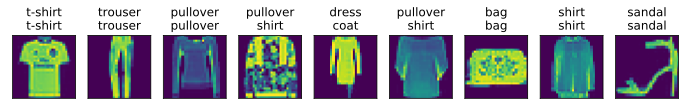

In [16]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])

## 小结
 
* 可以使用softmax回归做多类别分类。与训练线性回归相比，你会发现训练softmax回归的步骤和它非常相似：获取并读取数据、定义模型和损失函数并使用优化算法训练模型。事实上，绝大多数深度学习模型的训练都有着类似的步骤。

## 练习

* 在本节中，我们直接按照softmax运算的数学定义来实现softmax函数。这可能会造成什么问题？（提示：试一试计算$\exp(50)$的大小。）
* 本节中的`cross_entropy`函数是按照[“softmax回归”](softmax-regression.ipynb)一节中的交叉熵损失函数的数学定义实现的。这样的实现方式可能有什么问题？（提示：思考一下对数函数的定义域。）
* 你能想到哪些办法来解决上面的两个问题？



## 扫码直达[讨论区](https://discuss.gluon.ai/t/topic/741)

![](../img/qr_softmax-regression-scratch.svg)